# Plot Fisher information

Johann Brehmer, Kyle Cranmer, Marco Farina, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging
import os

import madminer.core
from madminer.plotting import plot_fisher_information_contours_2d

logging.basicConfig(format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s', datefmt='%H:%M', level=logging.DEBUG)


20:41 matplotlib.pyplot    DEBUG   Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [6]:
sample_dir = base_dir + 'data/samples/wgamma_sys/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma_sys/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma_sys/'
result_dir = base_dir + 'data/results/wgamma_sys/'

## Load Fisher information results

In [16]:
def load_data(ml_prefix = '', profiled=True):
    profile_prefix = 'profiled_' if profiled else ''
    
    # Ground truth
    infos  = [np.load(result_dir + profile_prefix + 'information_parton.npy'),
              np.load(result_dir + profile_prefix + 'information_rate_tight.npy')]
    covs   = [np.load(result_dir + profile_prefix + 'covariance_parton.npy'),
              np.load(result_dir + profile_prefix + 'covariance_rate_tight.npy')]
    labels = ['parton', 'xsec']
    colors = ['black', '0.5']
    lss    = [':', ':']
    
    # Histos
    histo_filenames = ['phi', 'deltaphi_lv', 'met', 'ptl', 'pta', 'deltaphi_la', ]
    histo_labels    = [r'$\varphi$', r'$\Delta\phi_{\ell\nu}$', 'MET', r'$p_{T,\ell}$', r'$p_{T,\gamma}$', r'$\Delta\phi_{\ell\gamma}$']
    histo_colors    = ['mediumblue', 'steelblue', 'dodgerblue', 'deepskyblue', 'cornflowerblue', 'b']
    histo_lss       = ['--']*10

    for hfilename, hlabel, hcolor, hls in zip(histo_filenames, histo_labels, histo_colors, histo_lss):
        infos.append(
            np.load(result_dir + profile_prefix + 'information_histo_{}_tight.npy'.format(hfilename))
        )
        covs.append(
            np.load(result_dir + profile_prefix + 'covariance_histo_{}_tight.npy'.format(hfilename))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    # ML
    ml_filenames = ['full', 'full_infomode', 'minimal', 'full_tight', 'minimal_tight', 'phi_tight']
    ml_labels    = ['full', 'full (I)', 'minimal', 'cuts', 'cuts min', r'$\varphi$']
    ml_colors    = ['#CC002E', 'firebrick', 'orangered', 'lightcoral', 'r', 'chocolate']
    ml_lss       = ['-', '-', '-', '-.', '-.', '--', ':']

    for hfilename, hlabel, hcolor, hls in zip(ml_filenames, ml_labels, ml_colors, ml_lss):
        infos.append(
            np.load(result_dir + profile_prefix + 'information_{}{}.npy'.format(hfilename, ml_prefix))
        )
        covs.append(
            np.load(result_dir + profile_prefix + 'covariance_{}{}.npy'.format(hfilename, ml_prefix))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    return infos, covs, labels, colors, lss


In [21]:
infos_profiled, covs_profiled, _, _, _ = load_data('', profiled=True)
infos, covs, labels, colors, lss = load_data('', profiled=False)

for i, (label, info, info_prof) in enumerate(zip(labels, infos, infos_profiled)):
    print(
        '{:2} {:10.10s}  I_00 = {:7.0f} (projected) / {:7.0f} (profiled)'.format(i, label, info[0,0], info_prof[0,0])
    )
    print(
        '               I_11 = {:7.0f} (projected) / {:7.0f} (profiled)'.format(info[1,1], info_prof[1,1])
    )
    

 0 parton      I_00 = 5403055 (projected) / 5380588 (profiled)
               I_11 = 5676946 (projected) / 5673980 (profiled)
 1 xsec        I_00 =       0 (projected) /       0 (profiled)
               I_11 =       0 (projected) /       0 (profiled)
 2 $\varphi$   I_00 =  449898 (projected) /  449794 (profiled)
               I_11 =    1026 (projected) /    1026 (profiled)
 3 $\Delta\ph  I_00 =  425664 (projected) /  421030 (profiled)
               I_11 =     106 (projected) /     105 (profiled)
 4 MET         I_00 =     426 (projected) /     413 (profiled)
               I_11 =      92 (projected) /      91 (profiled)
 5 $p_{T,\ell  I_00 =    2248 (projected) /    2167 (profiled)
               I_11 =     153 (projected) /     152 (profiled)
 6 $p_{T,\gam  I_00 =     120 (projected) /     120 (profiled)
               I_11 =     230 (projected) /     230 (profiled)
 7 $\Delta\ph  I_00 =  103707 (projected) /  103341 (profiled)
               I_11 =     124 (projected) /     123 (pr

## Plotting function

In [39]:
def make_plot(ml_prefix = '', indices=None, xmax=0.004):
    infos, covs, labels, colors, lss = load_data(ml_prefix, profiled=True)
    infos_projected, _, _, _, _ = load_data(ml_prefix, profiled=False)
    
    if indices is not None:
        infos = [infos[i] for i in indices]
        covs = [covs[i] for i in indices]
        labels = [labels[i] for i in indices]
        colors = [colors[i] for i in indices]
        lss = [lss[i] for i in indices]
        infos_projected = [infos_projected[i] for i in indices]
        
    infos_projected = [info[:2, :2] for info in infos_projected]

    fig = plot_fisher_information_contours_2d(
        fisher_information_matrices=infos_projected + infos,
        fisher_information_covariances=[None for _ in infos_projected] + covs,
        contour_distance=1.,
        xrange=(-xmax,xmax),
        yrange=(-xmax,xmax),
        xlabel=r'$f_{WWW}$',
        ylabel=r'$f_{\tilde{W}WW}$',
        linestyles=lss + lss,
        linewidths=[0.5 for _ in infos_projected] + [1.5 for _ in infos],
        colors=colors + colors,
        alphas=[1. for _ in infos_projected] + [1. for _ in infos],
        resolution=600,
        inline_labels=[None for _ in infos_projected] + labels
    )
    
    return fig


## Plots

21:14 madminer.plotting    DEBUG   Std: [[6.61704364 6.59502215 6.57308889 ... 9.76819177 9.796312   9.82450412]
 [6.59496606 6.57293014 6.55098232 ... 9.73090974 9.7590076  9.78717739]
 [6.57297667 6.55092642 6.52896417 ... 9.69373014 9.72180568 9.74995318]
 ...
 [9.74995318 9.72180568 9.69373014 ... 6.52896417 6.55092642 6.57297667]
 [9.78717739 9.7590076  9.73090974 ... 6.55098232 6.57293014 6.59496606]
 [9.82450412 9.796312   9.76819177 ... 6.57308889 6.59502215 6.61704364]]
21:14 madminer.plotting    DEBUG   Std: [[0.03381031 0.03360272 0.03339582 ... 0.03215697 0.03235983 0.03256338]
 [0.03379248 0.03358491 0.03337802 ... 0.03214343 0.03234629 0.03254983]
 [0.0337747  0.03356714 0.03336026 ... 0.03212993 0.03233279 0.03253633]
 ...
 [0.03253633 0.03233279 0.03212993 ... 0.03336026 0.03356714 0.0337747 ]
 [0.03254983 0.03234629 0.03214343 ... 0.03337802 0.03358491 0.03379248]
 [0.03256338 0.03235983 0.03215697 ... 0.03339582 0.03360272 0.03381031]]
21:14 madminer.plotting    DEBUG

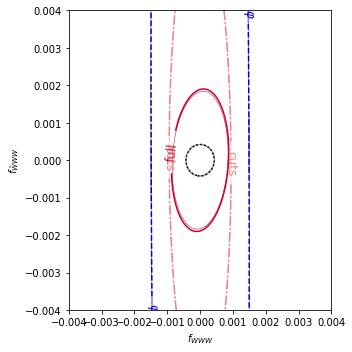

In [40]:
fig = make_plot('', xmax=0.004, indices=[0,2,8,11])

plt.savefig("../../figures/wgamma/information_wgamma.pdf")